In [30]:
# Initial setup
from __future__ import division
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import climlab
from builtins import next
from climlab.process.diagnostic import DiagnosticProcess
from climlab.domain.field import Field, global_mean

class tanalbedo(DiagnosticProcess):

    def __init__(self, **kwargs):
        super(tanalbedo, self).__init__(**kwargs)

        self.add_diagnostic('albedo')
        Ts = self.state['Ts']
        self._compute_fixed()

    def _compute_fixed(self):
        Ts = self.state['Ts']
        try:
            lon, lat = np.meshgrid(self.lon, self.lat)
        except:
            lat = self.lat
        phi = lat

        try:
            albedo=np.zeros(len(phi));
            albedo=0.42-0.20*np.tanh(0.052*(Ts-3))

        except:
            albedo = np.zeros_like(phi)

        dom = next(iter(self.domains.values()))
        self.albedo = Field(albedo, domain=dom)

    def _compute(self):
        self._compute_fixed()
        return {}


class simple_EBM_seasonal(climlab.model.ebm.EBM_seasonal):
    
    def __init__(self, orbit={'ecc': 0.0167643, 'long_peri': 280.32687, 'obliquity': 23.459277}, albedo='constant', Tf=-10.0, CO2=300, **kwargs):
        super().__init__(**kwargs)
        self.remove_subprocess('insolation')
        self.remove_subprocess('SW')
        self.remove_subprocess('albedo')
        self.remove_subprocess('LW')

        # catch model domain for subprocess creation
        surface = self.domains['Ts']
        # define new insolation and SW process
        insolation = climlab.radiation.DailyInsolation(domains=surface, orb = orbit, **self.param)
        
        # now define albedo process
        if albedo=='constant':
            alb = climlab.surface.albedo.ConstantAlbedo(domains=surface, **self.param)
        elif albedo=='step':
            alb = climlab.surface.albedo.StepFunctionAlbedo(state=self.state, Tf=Tf, **self.param)
        elif albedo=='tanh':
            alb = tanalbedo(state=self.state, **self.param)
        else:
            print('The given albedo option is not known. Will put in constant albedo.')
            alb = climlab.surface.albedo.ConstantAlbedo(domains=surface, **self.param)
        
        SW = climlab.radiation.absorbed_shorwave.SimpleAbsorbedShortwave(insolation=insolation.insolation, state = self.state, albedo = alb.albedo, **self.param)
        LW = climlab.radiation.aplusbt.AplusBT_CO2(CO2=CO2, state=self.state, **self.param)
        self.add_subprocess('LW', LW)
        self.add_subprocess('insolation', insolation)
        self.add_subprocess('SW', SW)
        self.add_subprocess('albedo', alb)
        self.compute_diagnostics()
    
    def global_annual_mean(self):
        num_steps_per_year = int(self.time['num_steps_per_year'])
        mean_year = np.empty(num_steps_per_year)
        for m in range(num_steps_per_year):
            self.step_forward()
            mean_year[m] = self.global_mean_temperature()
        gam = np.mean(mean_year)
        return gam
        
    def plot_temp_rad(self):
        # creating plot figure
        fig = plt.figure(figsize=(15,5))

        # Temperature plot
        ax1 = fig.add_subplot(121)
        ax1.plot(self.lat,self.Ts)

        ax1.set_xticks([-90,-60,-30,0,30,60,90])
        ax1.set_xlim([-90,90])
        ax1.set_title('Surface Temperature', fontsize=14)
        ax1.set_ylabel('(degC)', fontsize=12)
        ax1.grid()

        # Net Radiation plot
        ax3 = fig.add_subplot(122, sharex = ax1)
        ax3.plot(self.lat, self.OLR, label='OLR',
                                               color='cyan')
        ax3.plot(self.lat, self.ASR, label='ASR',
                                               color='magenta')
        ax3.plot(self.lat, self.ASR-self.OLR, 
                                               label='net radiation',
                                               color='red')

        ax3.set_title('Net Radiation', fontsize=14)
        ax3.set_ylabel('(W/m$^2$)', fontsize=12)
        ax3.legend(loc='best')
        ax3.grid()
        plt.show()
        
    def plot_timeave(self):
        # integrate for one year
        self.integrate_years(1.)
        
        # creating plot figure
        fig = plt.figure(figsize=(15,5))

        # Temperature plot
        ax1 = fig.add_subplot(121)
        ax1.plot(self.lat,self.timeave['Ts'])

        ax1.set_xticks([-90,-60,-30,0,30,60,90])
        ax1.set_xlim([-90,90])
        ax1.set_title('Annual mean Surface Temperature', fontsize=14)
        ax1.set_ylabel('(degC)', fontsize=12)
        ax1.grid()

        # Net Radiation plot
        ax3 = fig.add_subplot(122, sharex = ax1)
        ax3.plot(self.lat, self.timeave['OLR'], label='Annual mean OLR',
                                               color='cyan')
        ax3.plot(self.lat, self.timeave['ASR'], label='Annual mean ASR',
                                               color='magenta')
        ax3.plot(self.lat, self.timeave['ASR']-self.timeave['OLR'], 
                                               label='Annual mean net radiation',
                                               color='red')

        ax3.set_title('Annual mean Net Radiation', fontsize=14)
        ax3.set_ylabel('(W/m$^2$)', fontsize=12)
        ax3.legend(loc='best')
        ax3.grid()
        plt.show()
    
    def plot_albedo(self):
        fig = plt.figure(figsize=(7.5,5))

        # Temperature plot
        ax2 = fig.add_subplot(111)
        ax2.plot(self.lat,self.albedo)

        ax2.set_title('Albedo', fontsize=14)
        ax2.set_xlabel('latitude', fontsize=10)
        ax2.set_ylabel('', fontsize=12)

        ax2.set_xticks([-90,-60,-30,0,30,60,90])
        ax2.set_xlim([-90,90])
        ax2.set_ylim([0,1])
        ax2.grid()
    
        plt.show()
        
    def plot_temp_year(self):

        num_steps_per_year = int(self.time['num_steps_per_year'])
        Tyear = np.empty((self.lat.size, num_steps_per_year))
        for m in range(num_steps_per_year):
            self.step_forward()
            Tyear[:,m] = np.squeeze(self.Ts)
        Tmin=np.min(Tyear)
        Tmax=np.max(Tyear)
        
        fig = plt.figure(figsize=(5,5))
        ax = fig.add_subplot(111)
        
        factor = 365. / num_steps_per_year
        cax = ax.contourf(factor * np.arange(num_steps_per_year),
                      self.lat, Tyear[:,:], 
                      cmap=plt.cm.seismic, vmin=Tmin, vmax=Tmax)
        cbar1 = plt.colorbar(cax)
        ax.set_title('Temperatures throughout the year', fontsize=14)
        ax.set_xlabel('Days of year', fontsize=14)
        ax.set_ylabel('Latitude', fontsize=14)
        
    def plot_ice_year(self):
        
        if 'Tf' in self.subprocess['albedo'].param.keys():
            Tf = self.subprocess['albedo'].param['Tf']
        else:
            print('No ice considered in this model. Can not plot.')
            return

        num_steps_per_year = int(self.time['num_steps_per_year'])
        ice_year = np.empty((self.lat.size, num_steps_per_year))
        for m in range(num_steps_per_year):
            self.step_forward()
            ice_year[:,m] = np.where(np.squeeze(self.Ts) <= Tf, 0, 1)
        
        fig = plt.figure(figsize=(5,5))
        ax = fig.add_subplot(111)
        
        factor = 365. / num_steps_per_year
        cax = ax.contourf(factor * np.arange(num_steps_per_year),
                      self.lat, ice_year[:,:], 
                      cmap=plt.cm.seismic, vmin=0, vmax=1, levels=2)
        cbar1 = plt.colorbar(cax)
        ax.set_title('Ice throughout the year', fontsize=14)
        ax.set_xlabel('Days of year', fontsize=14)
        ax.set_ylabel('Latitude', fontsize=14)

In [31]:
# Investigating the effect of CO2 concentration
# Temperature change from doubling CO2 value in the atmosfere

ebm_co2_low = simple_EBM_seasonal(albedo='step', CO2=280)
ebm_co2_real = simple_EBM_seasonal(albedo='step', CO2=420)
ebm_co2_high = simple_EBM_seasonal(albedo='step', CO2=560)

In [32]:
ebm_co2_low.integrate_years(10.)
ebm_co2_low.plot_timeave()
# ebm_co2_low.plot_temp_year()
# ebm_co2_low.plot_ice_year()
plt.show()
print('The global annual mean is {}'.format(ebm_co2_low.global_annual_mean()))
print('Maximum temperature is', max(ebm_co2_low.timeave['Ts']))
print('Minimum temperature is', min(ebm_co2_low.timeave['Ts']))

Integrating for 900 steps, 3652.4220000000005 days, or 10.0 years.


Integrating for 8100 steps, 32871.798 days, or 90.0 years.
Total elapsed time is 102.0000000000137 years.
Integrating for 90 steps, 365.2422 days, or 1.0 years.
Total elapsed time is 103.00000000001388 years.


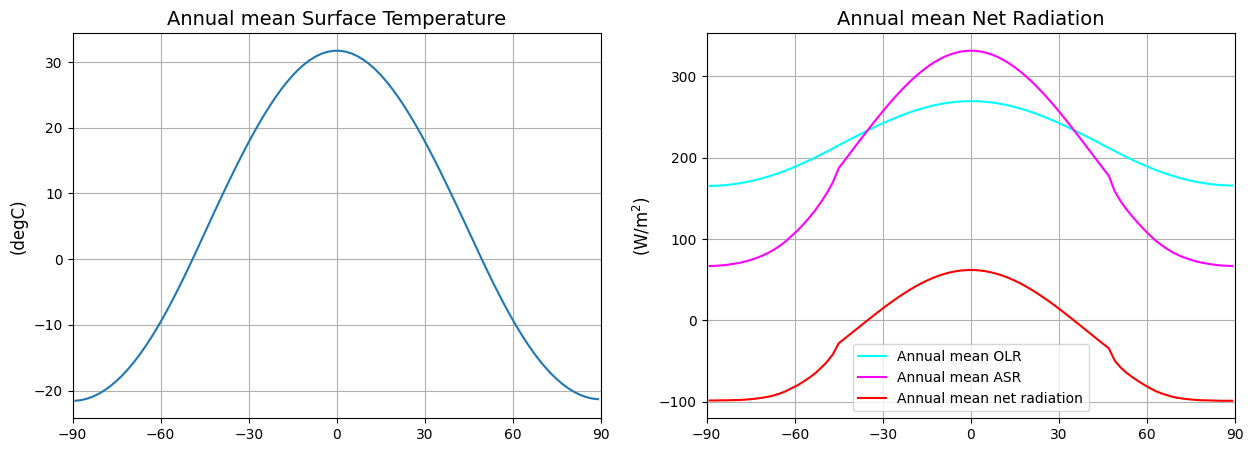

The global annual mean is 13.439595034917893
Maximum temperature is [31.71913247]
Minimum temperature is [31.71913247]


In [ ]:
ebm_co2_low.integrate_years(90.)
ebm_co2_low.plot_timeave()
# ebm_co2_low.plot_temp_year()
# ebm_co2_low.plot_ice_year()
plt.show()
print('The global annual mean is {}'.format(ebm_co2_low.global_annual_mean()))
print('Maximum temperature is', max(ebm_co2_low.timeave['Ts']))
print('Minimum temperature is', min(ebm_co2_low.timeave['Ts']))


In [ ]:
ebm_co2_real.integrate_years(10.)
ebm_co2_real.plot_timeave()
# ebm_co2_low.plot_temp_year()
# ebm_co2_low.plot_ice_year()
plt.show()
print('The global annual mean is {}'.format(ebm_co2_real.global_annual_mean()))
print('Maximum temperature is', max(ebm_co2_real.timeave['Ts']))
print('Minimum temperature is', min(ebm_co2_real.timeave['Ts']))


In [ ]:
ebm_co2_real.integrate_years(90.)
ebm_co2_real.plot_timeave()
# ebm_co2_low.plot_temp_year()
# ebm_co2_low.plot_ice_year()
plt.show()
print('The global annual mean is {}'.format(ebm_co2_real.global_annual_mean()))
print('Maximum temperature is', max(ebm_co2_real.timeave['Ts']))
print('Minimum temperature is', min(ebm_co2_real.timeave['Ts']))

Integrating for 900 steps, 3652.4220000000005 days, or 10.0 years.
Total elapsed time is 9.999999999999863 years.
Integrating for 90 steps, 365.2422 days, or 1.0 years.
Total elapsed time is 10.999999999999819 years.


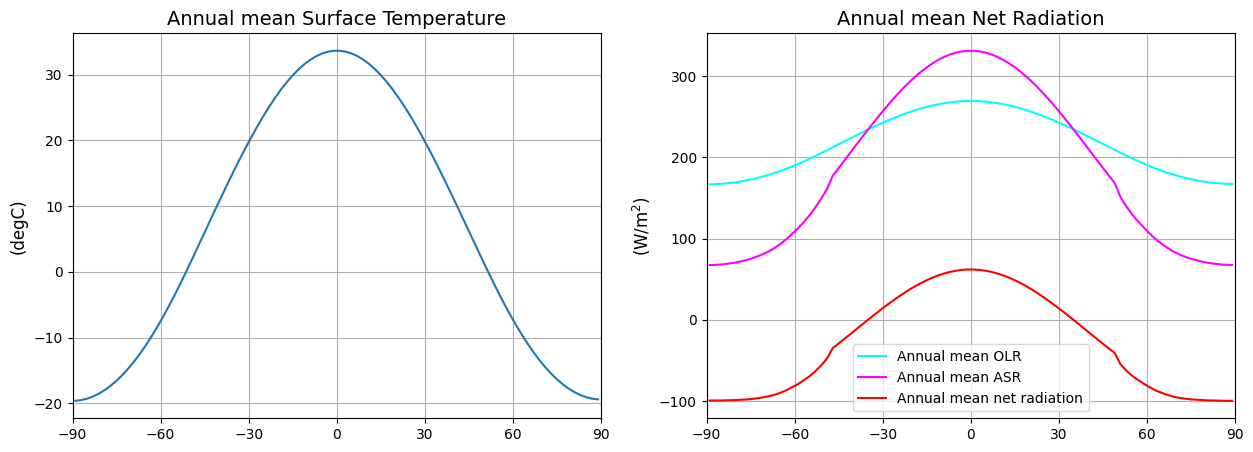

The global annual mean is 15.396837036926783
Maximum temperature is [33.63011092]
Minimum temperature is [33.63011092]


In [ ]:
ebm_co2_high.integrate_years(10.)
ebm_co2_high.plot_timeave()
# ebm_co2_high.plot_temp_year()
# ebm_co2_high.plot_ice_year()
plt.show()
print('The global annual mean is {}'.format(ebm_co2_high.global_annual_mean()))
print('Maximum temperature is', max(ebm_co2_high.timeave['Ts']))
print('Minimum temperature is', min(ebm_co2_high.timeave['Ts']))

Integrating for 8100 steps, 32871.798 days, or 90.0 years.
Total elapsed time is 102.0000000000137 years.
Integrating for 90 steps, 365.2422 days, or 1.0 years.
Total elapsed time is 103.00000000001388 years.


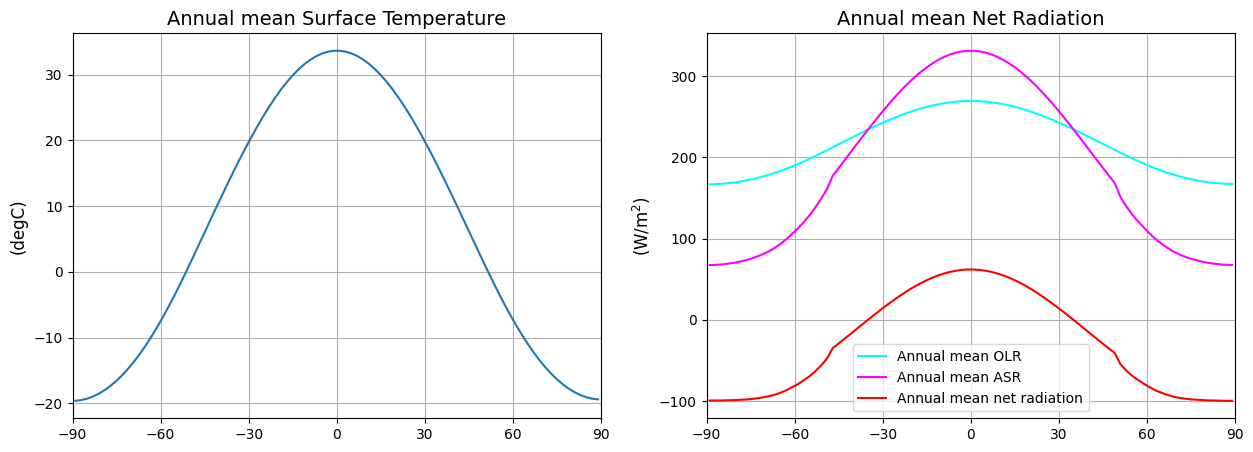

The global annual mean is 15.396837566192271
Maximum temperature is [33.63011321]
Minimum temperature is [33.63011321]


In [ ]:
ebm_co2_high.integrate_years(90.)
ebm_co2_high.plot_timeave()
# ebm_co2_high.plot_temp_year()
# ebm_co2_high.plot_ice_year()
plt.show()
print('The global annual mean is {}'.format(ebm_co2_high.global_annual_mean()))
print('Maximum temperature is', max(ebm_co2_high.timeave['Ts']))
print('Minimum temperature is', min(ebm_co2_high.timeave['Ts']))